# Exploring the application of quantum circuits in convolutional neural networks

This tutorial will guide you through implementing a hybrid quantum-classical convolutional neural network using Tequila along with other packages such as Tensorflow. We will then train the model on the MNIST dataset, which contains images of handwritten numbers classifed according to the digit they represent. Finally, we will compare the accuracy and loss of models with and without the quantum preprocessing.

Inspriation for this tutorial comes from [Pennylane: Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution.html). We will similarly follow the method proposed in the reference paper used for this tutorial, [Henderson at al (2020)](https://doi.org/10.1007/s42484-020-00012-y).

## Background

#### Convolutional Neural Nets

An excellent high-level explanation of convolutional neural networks can be found [here](https://www.youtube.com/watch?v=FmpDIaiMIeA). Alternatively, an excellent written explanation can be found [here](http://neuralnetworksanddeeplearning.com/chap6.html) and for more information, the wikipedia article can be found [here](https://en.wikipedia.org/wiki/Convolutional_neural_network).

In summary, a convolutional neural network includes preprocessing layers prior to optimisation layers so that features in the input (which are often images) are extracted and amplified. The result is a model with greater predictive power. This processing also improves classification of images as it extracts features even if they are translocated between images. This means that searching for a particular pixel distribution (for example the shape of a curve or line may be a useful feature when classifying digits) is not dependant on the distribution being in an identical location in each image where it is present. The convolutional process extracts this information even if it is slightly rotated or translocated.

The implementation of the convolutional layer involves a grid for each feature being passed over the entire image. At each location, a score is calculated representing how well the feature and the section of the image match, and this becomes the value of the corresponding pixel in the output image. As a guide, a large score represents a close match, generally meaning that the feature is present at that location of the image, and a low score represents the absence of a match.

#### Our Approach

Our general approach is similar to that used in a conventional convolutional neural network however the initial processing occurs by running the images through a quantum circuit instead of a convolutional filter. Each simulation of a circuit represents one 3x3 filter being applied to one 3x3 region of one image. The construction of the circuit is randomised (see below), however this construction only occurs once per filter such that each region of the image being transformed by the same filter gets run through the same circuit. A single, scalar output is generated from the circuit which is used as the pixel strength of the output image, and the remainder of the neural net uses only classical processing, specifically two further convolutional layers, max pooling and two fully connected layers. This architecture has been chosen to closely mimic the structure used in our reference paper (Henderson et al, 2020), however as they note, "The QNN topology chosen in this work is not fixed by nature ... the QNN framework was designed to give users complete control over the number and order of quanvolutional layers in the architecture. The topology explored in this work was chosen because it was the simplest QNN architecture to use as a baseline for comparison against other purely classical networks. Future work would focus on exploring the impact of more complex architectural variations."

<div>
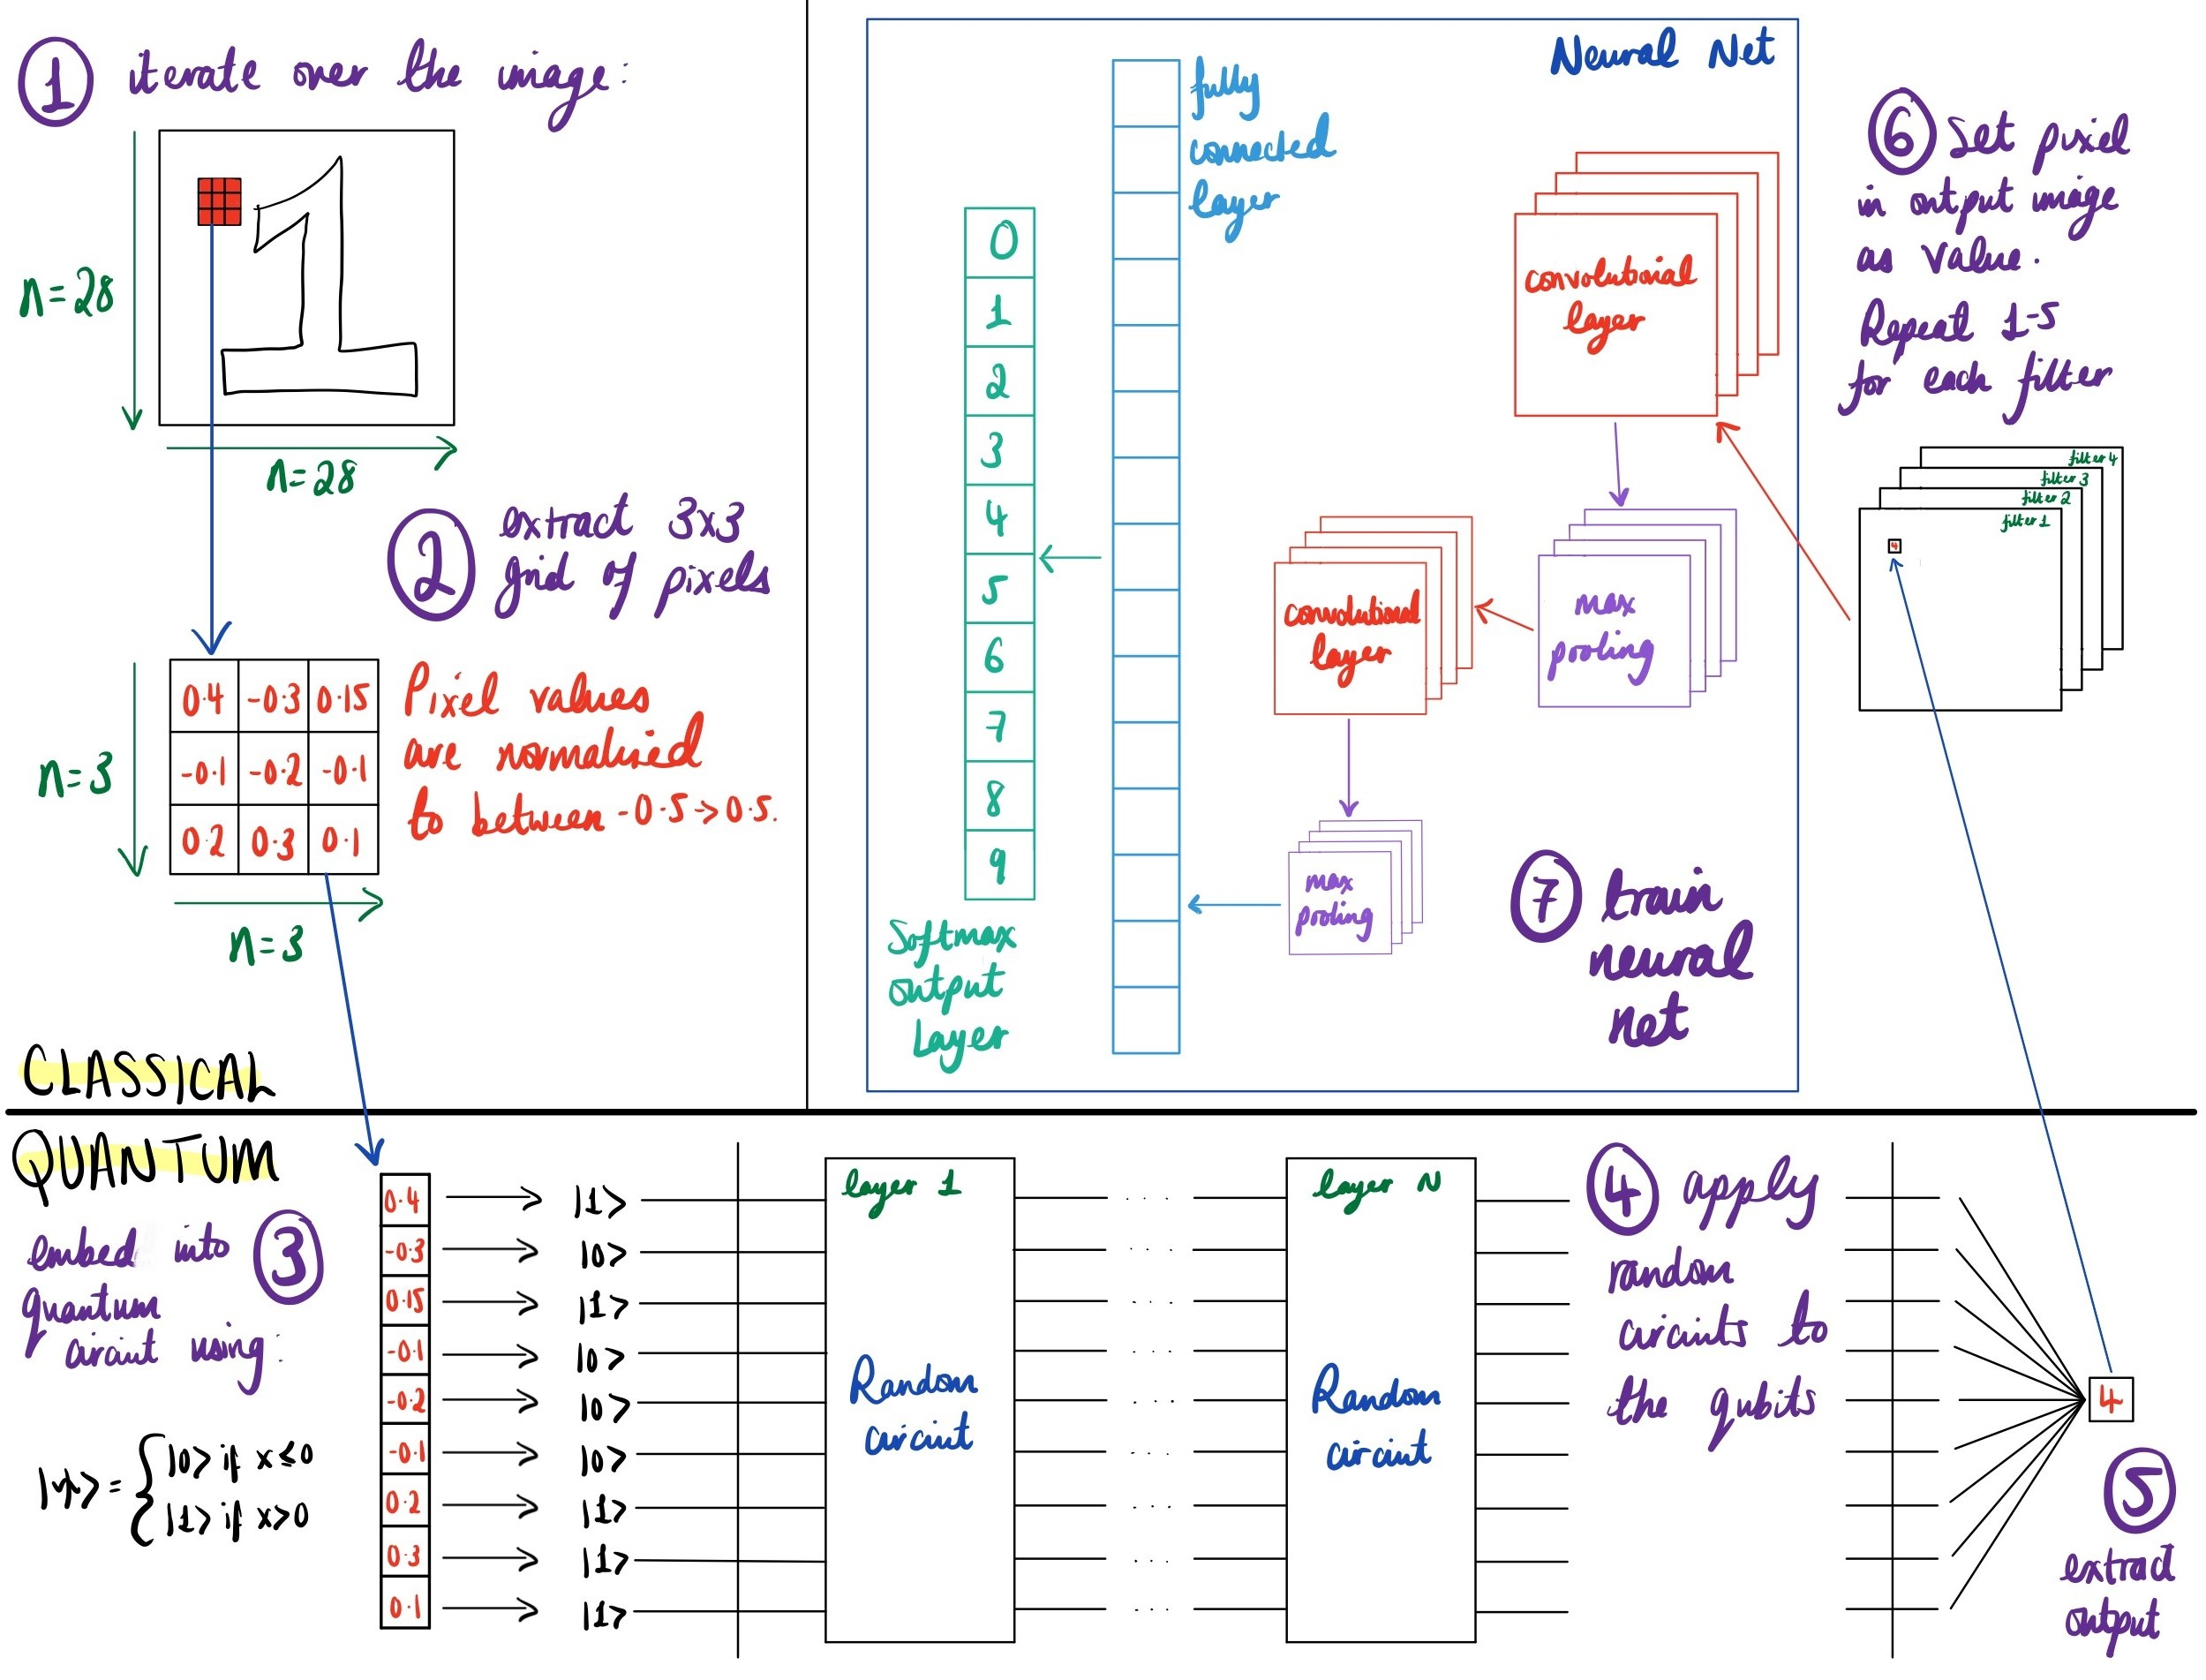
</div>

#### Quantum Processing

Henderson et al summarise the use of quantum circuits as convolutional layers: "Quanvolutional layers are made up of a group of N quantum filters which operate much like their classical convolutional layer counterparts, producing feature maps by locally transforming input data. The key difference is that quanvolutional filters extract features from input data by transforming spatially local subsections of data using quantum circuits." Our approach to the circuit design is based on the paper and is as follows:

1) The input images are iterated over and each 3x3 region is embedded into the quantum circuit using the threshold function: 
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\ket{\psi} = \begin{cases} 
                      \ket{0} & if & strength\leq 0 \\
                      \ket{1} & if & strength > 0
                   \end{cases}$$ 

As the pixel strengths are normalised to values between -0.5 and 0.5, it is expected that brighter regions of the image will intialise their corresponding qubit in the state $\ket{1}$ and darker regions will intitialise the state $\ket{0}$. Each pixel is represented by one qubit, such that 9 qubits are used in total, and this quantum circuit is reused for each 3x3 square in the filter.

2) We next apply a random circuit to the qubits. To implement this, a random choice from Rx, Ry and Rz gates is applied to a random qubit, and the total number of gates applied in each layer is equal to the number of qubits. With a set probability (which we set to 0.3), a CNOT gate will be applied instead of the rotation to two random qubits. We have chosen to set the parameters of rotation with random numbers between (0,2π) however futher optimisation of the model could be found from using a variational circuit and optimising these parameters.

3) Further layers could be applied of the random gates. To simplify, we only apply one layer.

4) A scalar is outputted from the circuit and used as the corresponding pixel in the output image. We generate this number using the following method. The state vector of the final state of the circuit is simulated and the state corresponding to the most likely output (largest modulus) is selected. We then calculate the number of qubits for this state which are measured as a $\ket{1}$. 

5) A total of four filters are applied to each image, and for each filter steps 1-3 are repeated with a different randomised circuit. The output image therefore contains a third dimension with four channels representing the four different outputted values which each filters produced.

<div>
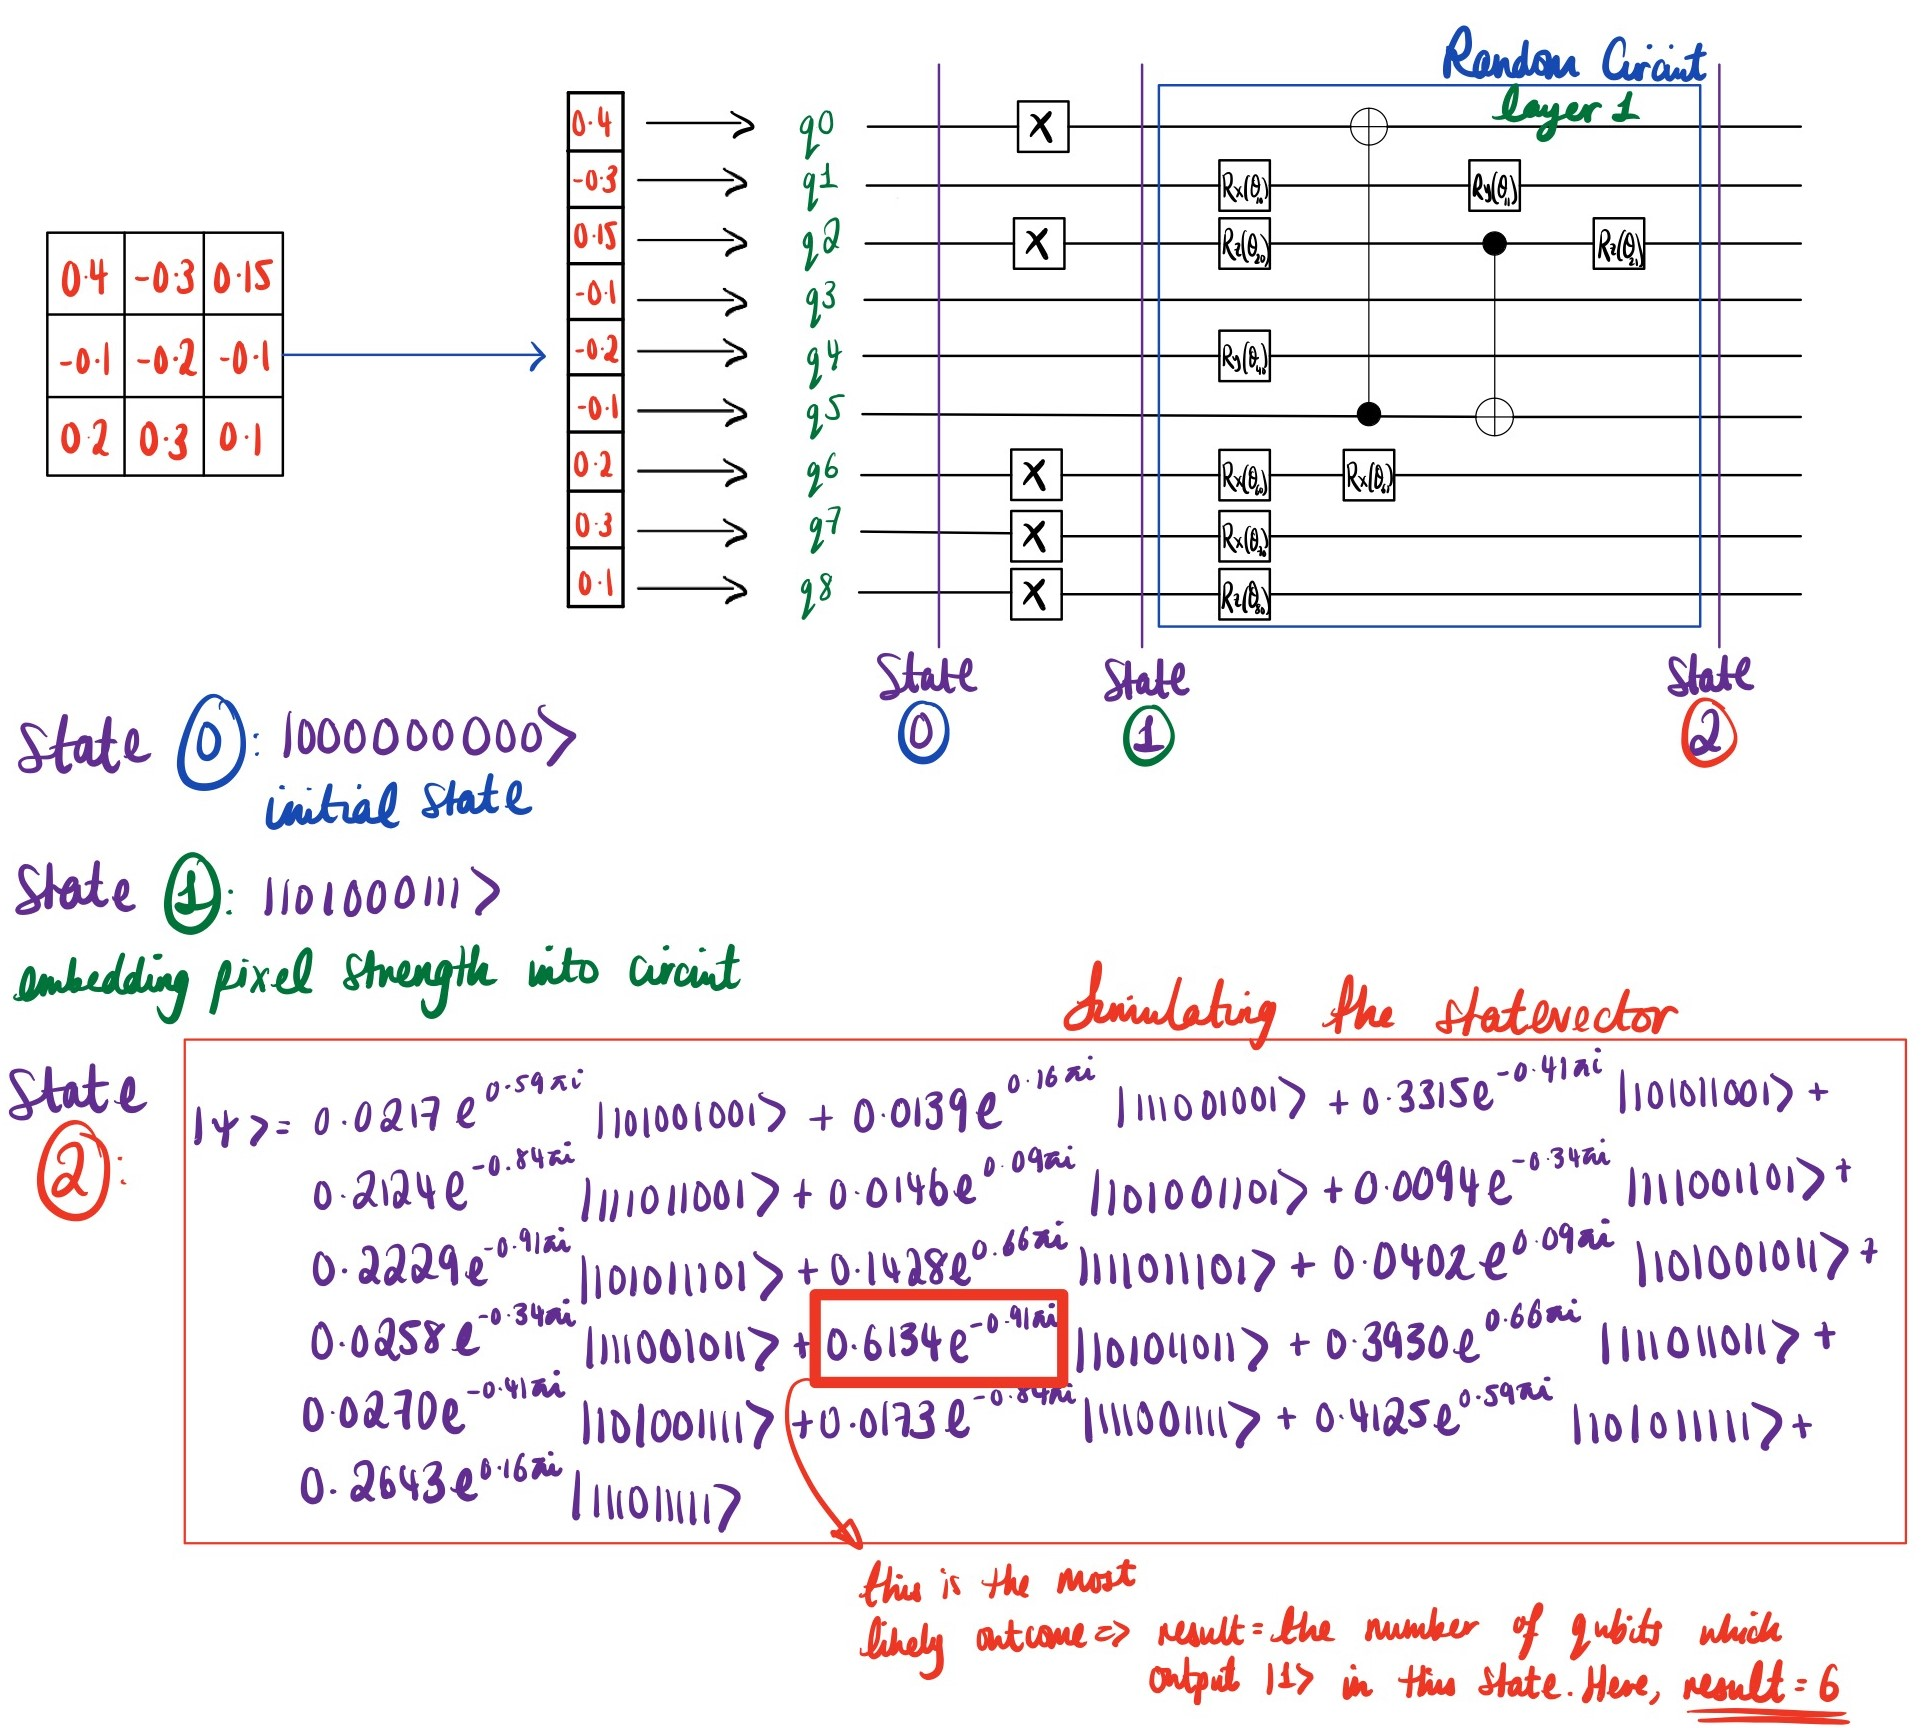
</div>

## Code and Running the Program

The following code cell is used to import the necessary packages and to set parameters.

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tequila as tq

from operator import itemgetter
from tensorflow import keras

n_filters = 4               # Number of convolutional filters
filter_size = 3             # Size of filter = nxn (here 3x3)
pool_size = 2               # Used for the pooling layer
n_qubits = filter_size ** 2 # Number of qubits
n_layers = 1                # Number of quantum circuit layers
n_train = 1000              # Size of the training dataset
n_test = 200                # Size of the testing dataset
n_epochs = 100              # Number of optimization epochs

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = False          # If False, skip quantum processing and load data from SAVE_PATH
tf.random.set_seed(1)       # Seed for TensorFlow random number generator

We start by creating the Dataset class. Here, we load the images and labels of handwritten digits from the MNIST dataset. We then reduce the number of images from 60,000 and 10,000 (for the training and testing sets respectively) down to the variables n_train and n_test, normalise the pixel values to within the range (-0.5,0.5) and reshape the images by adding a third dimension. Each image's shape is therefore transformed from (28, 28) to (28, 28, 1) as this is necessary for the convolutional layer.

In [ ]:
class Dataset:

    def __init__(self):
        # Loading the full dataset of images from keras
        # Shape of self.train_images is (60000, 28, 28), shape of self.train_labels is (60000,)
        # For self.test_images and self.test_labels, shapes are (10000, 28, 28) and (10000,)
        mnist_dataset = keras.datasets.mnist
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = mnist_dataset.load_data()

        # Reduce dataset size to n_train and n_test
        # First dimension of shapes are reduced to n_train and n_test
        self.train_images = self.train_images[:n_train]
        self.train_labels = self.train_labels[:n_train]
        self.test_images = self.test_images[:n_test]
        self.test_labels = self.test_labels[:n_test]

        # Normalize pixel values within -0.5 and +0.5
        self.train_images = (self.train_images / 255) - 0.5
        self.test_images = (self.test_images / 255) - 0.5

        # Add extra dimension for convolution channels
        self.train_images = self.train_images[..., tf.newaxis]
        self.test_images = self.test_images[..., tf.newaxis]

The next code cell contains the class used to generate the quantum circuit. In theory, the circuit could be either structured or random. We form a randomised circuit to match the reference paper (Henderson et al, 2020), however for simplicity, our implementation differs in some ways. We choose to use only use single qubit Rx($\theta$), Ry($\theta$) and Rz($\theta$) gates and the two qubit CNOT gate compared to the choice of single qubit X($\theta$), Y($\theta$), Z($\theta$), U($\theta$), P, T, H and two qubit CNOT, SWAP, SQRTSWAP, or CU gates used in the paper. Furthermore, we chose to assign a two qubit gate to any random qubits with a certain probability (labelled ratio_imprim, set to 0.3) rather than setting a connection probabiltiy between each pair of qubits (this approach follows the Pennylane tutorial). The seed is used for reproducability and its value is set depending on which filter the circuit represents (see QuantumModel below).

The parameters used for the rotation gates have the potential to be optimised using a cost function. For simplicity, and to mirror the paper, here we will use random parameters and we will not include these in the optimisation of the model. This means that the quantum processing only needs to happen once, prior to creating the neural net.

In [ ]:
class QuantumCircuit:
    
    def __init__(self, seed=None):
        # Set random seed for reproducability
        if seed: np.random.seed(seed)
        
        # Encode classical information into quantum circuit
        # Bit flip gate is applied if the pixel strength > 0
        self.circ = tq.QCircuit()
        for i in range(n_qubits):
            self.circ += tq.gates.X(i, power='input_{}'.format(i))

        # Add random layers to the circuit
        self.circ += self.random_layers()
    
    def random_layers(self, ratio_imprim=0.3):
        # Initialise circuit
        circuit = tq.QCircuit()

        # Iterate over the number of layers, adding rotational and CNOT gates
        # The number of rotational gates added per layer is equal to the number of qubits in the circuit
        for i in range(n_layers):
            j = 0
            while (j < n_qubits):
                if np.random.random() > ratio_imprim:
                    # Applies a random rotation gate to a random qubit with probability (1 - ratio_imprim)
                    rnd_qubit = np.random.randint(n_qubits)
                    circuit += np.random.choice(
                        [tq.gates.Rx(angle='l_{},th_{}'.format(i,j), target=rnd_qubit),
                         tq.gates.Ry(angle='l_{},th_{}'.format(i,j), target=rnd_qubit),
                         tq.gates.Rz(angle='l_{},th_{}'.format(i,j), target=rnd_qubit)])
                    j += 1
                else:
                    # Applies the CNOT gate to 2 random qubits with probability ratio_imprim
                    if n_qubits > 1:
                        rnd_qubits = np.random.choice(range(n_qubits), 2, replace=False)
                        circuit += tq.gates.CNOT(target=rnd_qubits[0], control=rnd_qubits[1])
        return circuit

As an example to show the circuit used in this program, an instance of a circuit is drawn below. This will differ between calls if you remove the seed variable due to the random nature of forming the circuit.

In [ ]:
circuit = QuantumCircuit(seed=2)
tq.draw(circuit.circ, backend='qiskit')

We next show the QuantumModel class, used to generate the neural network for the images which undergo pre-processing through the quantum convolutional layer. If PREPROCESSING is set to True, each image from the dataset undergoes processing through a number of quantum circuits, determined by n_filters. The embedding used, the structure of the circuit and the method of extracting the output are described in the background of this tutorial. 

We use tensorflow to construct the neural net. The implementation we use contains two conventional convolutional layers, each followed by max pooling, and then one fully connected with 1024 nodes before the softmax output layer. We use a Relu activation function for the convolutional and fully connected layers. See the background section of this tutorial for some context on this choice of neural net.

In [ ]:
class QuantumModel:

    def __init__(self, dataset, parameters):
        # Initialize dataset and parameters
        self.ds = dataset
        self.params = parameters
        
        # The images are run through the quantum convolutional layer
        self.convolutional_layer()

        # The model is initialized
        self.model = keras.models.Sequential([
            keras.layers.Conv2D(n_filters, filter_size, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=pool_size),
            keras.layers.Conv2D(n_filters, filter_size, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=pool_size),
            keras.layers.Flatten(),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dense(10, activation="softmax")
        ])

        # Compile model using the Adam optimiser
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
    
    def convolutional_layer(self):
        if PREPROCESS == True:
            # Initate arrays to store processed images
            self.q_train_images = [np.zeros((28-2, 28-2, n_filters)) for _ in range(len(self.ds.train_images))]
            self.q_test_images = [np.zeros((28-2, 28-2, n_filters)) for _ in range(len(self.ds.test_images))]
            
            # Loop over the number of filters, applying a different randomised quantum circuit for each
            for i in range(n_filters):
                print('Filter {}/{}\n'.format(i+1, n_filters))
                
                # Construct circuit
                # We set the seed to be i+1 so that the circuits are reproducable but the design differs between filters
                # We use i+1 not i to avoid setting the seed as 0 which sometimes produces random behaviour
                circuit = QuantumCircuit(seed=i+1)
                
                # Apply the quantum processing to the train_images, analogous to a convolutional layer
                print("Quantum pre-processing of train images:")
                for j, img in enumerate(self.ds.train_images):
                    print("{}/{}        ".format(j+1, n_train), end="\r")
                    self.q_train_images[j][...,i] = (self.filter_(img, circuit, self.params[i]))
                print('\n')

                # Similarly for the test_images
                print("Quantum pre-processing of test images:")
                for j, img in enumerate(self.ds.test_images):
                    print("{}/{}        ".format(j+1, n_test), end="\r")
                    self.q_test_images[j][...,i] = (self.filter_(img, circuit, self.params[i]))
                print('\n')

            # Transform images to numpy array
            self.q_train_images = np.asarray(self.q_train_images)
            self.q_test_images = np.asarray(self.q_test_images)
            
            # Save pre-processed images
            np.save(SAVE_PATH + "q_train_images.npy", self.q_train_images)
            np.save(SAVE_PATH + "q_test_images.npy", self.q_test_images)
        
        # Load pre-processed images
        self.q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
        self.q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

    def filter_(self, image, circuit, variables):
        # Initialize output image
        output = np.zeros((28-2, 28-2))

        # Loop over the image co-ordinates (i,j) using a 3x3 square filter
        for i in range(28-2):
            for j in range(28-2):

                # Extract the value of each pixel in the 3x3 filter grid
                image_pixels = [
                    image[i,j,0],
                    image[i,j+1,0],
                    image[i,j+2,0],
                    image[i+1,j,0],
                    image[i+1,j+1,0],
                    image[i+1,j+2,0],
                    image[i+2,j,0],
                    image[i+2,j+1,0],
                    image[i+2,j+2,0]
                ]

                # Construct parameters used to embed the pixel strength into the circuit
                input_variables = {}
                for idx, strength in enumerate(image_pixels):
                    # If strength > 0, the power of the bit flip gate is 1
                    # Therefore this qubit starts in state |1>
                    if strength > 0:
                        input_variables['input_{}'.format(idx)] = 1
                    # Otherwise the gate is not applied and the initial state is |0>
                    else:
                        input_variables['input_{}'.format(idx)] = 0

                # Find the statevector of the circuit and determine the state which is most likely to be measured
                wavefunction = tq.simulate(circuit.circ, variables={**variables, **input_variables})
                amplitudes = [(k,(abs(wavefunction(k)))) for k in range(2**n_qubits) if wavefunction(k)]
                max_idx = max(amplitudes,key=itemgetter(1))[0]
                
                # Count the number of qubits which output '1' in this state
                result = len([k for k in str(bin(max_idx))[2::] if k == '1'])
                output[i,j] = result
        return output

    def train(self):
        # Train the model on the dataset
        self.history = self.model.fit(
            self.q_train_images,
            self.ds.train_labels,
            validation_data=(self.q_test_images, self.ds.test_labels),
            batch_size=4,
            epochs=n_epochs,
            verbose=2
        )

We also create a ClassicalModel class to run the images through a conventional convolutional neural network. The design of the neural net used here is identical to the QuantumModel class, however the images used are directly from the dataset and therefore have not been processed through the quantum layer. We include this as a control to compare the results from the quantum model.

In [ ]:
class ClassicalModel:

    def __init__(self, dataset):
        # Initialize dataset and parameters
        self.ds = dataset

        # The model is initialized
        self.model = keras.models.Sequential([
            keras.layers.Conv2D(n_filters, filter_size, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=pool_size),
            keras.layers.Conv2D(n_filters, filter_size, activation='relu'),
            keras.layers.MaxPooling2D(pool_size=pool_size),
            keras.layers.Flatten(),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dense(10, activation="softmax")
        ])

        # Compile model using the Adam optimiser
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.00005),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
    
    def train(self):
        # Train the model on the dataset
        self.history = self.model.fit(
            self.ds.train_images,
            self.ds.train_labels,
            validation_data=(self.ds.test_images, self.ds.test_labels),
            batch_size=4,
            epochs=n_epochs,
            verbose=2
        )

We are now able to run our program! The following code does this using the quantum_model and classical_model functions. Although the implementations are similar, quantum_model additionally defines the parameters used for the rotational gates in the circuit. We have limited the value of each parameter to the range (0,2π).

Running the program takes some time. Our results are plotted below, so if you would rather not wait, either reduce the numbers in n_train and n_test or skip ahead!

In [ ]:
def quantum_model():
    # Generating parameters, each maps to a random number between 0 and 2*π
    # parameters is a list of dictionaries, where each dictionary represents the parameter
    # mapping for one filter
    parameters = []
    for i in range(n_filters):
        filter_params = {}
        for j in range(n_layers):
            for k in range(n_qubits):
                filter_params[tq.Variable(name='l_{},th_{}'.format(j,k))] = np.random.uniform(high=2*np.pi)
        parameters.append(filter_params)
        
    # Initalise the dataset
    ds = Dataset()
    
    # Initialise and train the model
    model = QuantumModel(ds, parameters=parameters)
    model.train()
    
    # Store the loss and accuracy of the model to return
    loss = model.history.history['val_loss']
    accuracy = model.history.history['val_accuracy']

    return model

def classical_model():
    # Initialise the dataset
    ds = Dataset()
    
    # Initialise and train the model
    model = ClassicalModel(ds)
    model.train()
    
    # Store the loss and accuracy of the model to return
    loss = model.history.history['val_loss']
    accuracy = model.history.history['val_accuracy']
    
    return model

model_q = quantum_model()
model_c = classical_model()

<details>
  <summary>Our results are printed here. Click to expand.</summary>
  
  ##### Quantum Model:
Epoch 1/100  
250/250 - 1s - loss: 2.3172 - accuracy: 0.0840 - val_loss: 2.2986 - val_accuracy: 0.0500  
Epoch 2/100  
250/250 - 1s - loss: 2.2431 - accuracy: 0.1720 - val_loss: 2.2372 - val_accuracy: 0.1300  
Epoch 3/100  
250/250 - 1s - loss: 2.1735 - accuracy: 0.2780 - val_loss: 2.1707 - val_accuracy: 0.2200  
Epoch 4/100  
250/250 - 1s - loss: 2.0950 - accuracy: 0.4240 - val_loss: 2.0931 - val_accuracy: 0.3800  
Epoch 5/100  
250/250 - 1s - loss: 2.0030 - accuracy: 0.5590 - val_loss: 2.0019 - val_accuracy: 0.5000  
Epoch 6/100  
250/250 - 1s - loss: 1.8973 - accuracy: 0.6210 - val_loss: 1.8967 - val_accuracy: 0.5600  
Epoch 7/100  
250/250 - 1s - loss: 1.7784 - accuracy: 0.6940 - val_loss: 1.7868 - val_accuracy: 0.6600  
Epoch 8/100  
250/250 - 1s - loss: 1.6532 - accuracy: 0.7540 - val_loss: 1.6685 - val_accuracy: 0.7100  
Epoch 9/100  
250/250 - 1s - loss: 1.5266 - accuracy: 0.7660 - val_loss: 1.5553 - val_accuracy: 0.7300  
Epoch 10/100  
250/250 - 1s - loss: 1.4104 - accuracy: 0.8010 - val_loss: 1.4467 - val_accuracy: 0.7450  
Epoch 11/100  
250/250 - 1s - loss: 1.3057 - accuracy: 0.8090 - val_loss: 1.3506 - val_accuracy: 0.7550  
Epoch 12/100  
250/250 - 1s - loss: 1.2099 - accuracy: 0.8180 - val_loss: 1.2628 - val_accuracy: 0.7700  
Epoch 13/100  
250/250 - 1s - loss: 1.1248 - accuracy: 0.8290 - val_loss: 1.1759 - val_accuracy: 0.7950  
Epoch 14/100  
250/250 - 1s - loss: 1.0502 - accuracy: 0.8340 - val_loss: 1.1059 - val_accuracy: 0.8100  
Epoch 15/100  
250/250 - 1s - loss: 0.9846 - accuracy: 0.8430 - val_loss: 1.0433 - val_accuracy: 0.8100  
Epoch 16/100  
250/250 - 1s - loss: 0.9244 - accuracy: 0.8460 - val_loss: 0.9837 - val_accuracy: 0.8100  
Epoch 17/100  
250/250 - 1s - loss: 0.8709 - accuracy: 0.8480 - val_loss: 0.9302 - val_accuracy: 0.8400  
Epoch 18/100  
250/250 - 1s - loss: 0.8257 - accuracy: 0.8510 - val_loss: 0.8713 - val_accuracy: 0.8500  
Epoch 19/100  
250/250 - 1s - loss: 0.7829 - accuracy: 0.8510 - val_loss: 0.8299 - val_accuracy: 0.8550  
Epoch 20/100  
250/250 - 1s - loss: 0.7468 - accuracy: 0.8570 - val_loss: 0.7957 - val_accuracy: 0.8650  
Epoch 21/100  
250/250 - 1s - loss: 0.7112 - accuracy: 0.8590 - val_loss: 0.7679 - val_accuracy: 0.8650  
Epoch 22/100  
250/250 - 1s - loss: 0.6799 - accuracy: 0.8660 - val_loss: 0.7252 - val_accuracy: 0.8750  
Epoch 23/100  
250/250 - 1s - loss: 0.6534 - accuracy: 0.8690 - val_loss: 0.7152 - val_accuracy: 0.8450  
Epoch 24/100  
250/250 - 1s - loss: 0.6300 - accuracy: 0.8710 - val_loss: 0.6633 - val_accuracy: 0.8800  
Epoch 25/100  
250/250 - 1s - loss: 0.6063 - accuracy: 0.8710 - val_loss: 0.6309 - val_accuracy: 0.8900  
Epoch 26/100  
250/250 - 1s - loss: 0.5872 - accuracy: 0.8720 - val_loss: 0.6224 - val_accuracy: 0.8950  
Epoch 27/100  
250/250 - 1s - loss: 0.5686 - accuracy: 0.8780 - val_loss: 0.5896 - val_accuracy: 0.8850  
Epoch 28/100  
250/250 - 1s - loss: 0.5503 - accuracy: 0.8750 - val_loss: 0.5791 - val_accuracy: 0.9000  
Epoch 29/100  
250/250 - 1s - loss: 0.5364 - accuracy: 0.8770 - val_loss: 0.5548 - val_accuracy: 0.8800  
Epoch 30/100  
250/250 - 1s - loss: 0.5207 - accuracy: 0.8790 - val_loss: 0.5470 - val_accuracy: 0.8900  
Epoch 31/100  
250/250 - 1s - loss: 0.5094 - accuracy: 0.8800 - val_loss: 0.5319 - val_accuracy: 0.8900  
Epoch 32/100  
250/250 - 1s - loss: 0.4959 - accuracy: 0.8830 - val_loss: 0.5087 - val_accuracy: 0.8800  
Epoch 33/100  
250/250 - 1s - loss: 0.4842 - accuracy: 0.8870 - val_loss: 0.4921 - val_accuracy: 0.8900  
Epoch 34/100  
250/250 - 1s - loss: 0.4722 - accuracy: 0.8850 - val_loss: 0.4890 - val_accuracy: 0.8850  
Epoch 35/100  
250/250 - 1s - loss: 0.4636 - accuracy: 0.8900 - val_loss: 0.4761 - val_accuracy: 0.9100  
Epoch 36/100  
250/250 - 1s - loss: 0.4520 - accuracy: 0.8890 - val_loss: 0.4608 - val_accuracy: 0.9100  
Epoch 37/100  
250/250 - 1s - loss: 0.4448 - accuracy: 0.8880 - val_loss: 0.4490 - val_accuracy: 0.9250  
Epoch 38/100  
250/250 - 1s - loss: 0.4355 - accuracy: 0.8940 - val_loss: 0.4505 - val_accuracy: 0.9100  
Epoch 39/100  
250/250 - 1s - loss: 0.4269 - accuracy: 0.8950 - val_loss: 0.4309 - val_accuracy: 0.9150  
Epoch 40/100  
250/250 - 1s - loss: 0.4189 - accuracy: 0.8910 - val_loss: 0.4246 - val_accuracy: 0.9000  
Epoch 41/100  
250/250 - 1s - loss: 0.4126 - accuracy: 0.8900 - val_loss: 0.4202 - val_accuracy: 0.9150  
Epoch 42/100  
250/250 - 1s - loss: 0.4051 - accuracy: 0.9020 - val_loss: 0.4032 - val_accuracy: 0.9300  
Epoch 43/100  
250/250 - 1s - loss: 0.3975 - accuracy: 0.9000 - val_loss: 0.3962 - val_accuracy: 0.9250  
Epoch 44/100  
250/250 - 1s - loss: 0.3932 - accuracy: 0.9050 - val_loss: 0.3968 - val_accuracy: 0.9250  
Epoch 45/100  
250/250 - 1s - loss: 0.3862 - accuracy: 0.9030 - val_loss: 0.3816 - val_accuracy: 0.9200  
Epoch 46/100  
250/250 - 1s - loss: 0.3790 - accuracy: 0.9010 - val_loss: 0.3932 - val_accuracy: 0.9200  
Epoch 47/100  
250/250 - 1s - loss: 0.3740 - accuracy: 0.9030 - val_loss: 0.3675 - val_accuracy: 0.9300  
Epoch 48/100  
250/250 - 1s - loss: 0.3690 - accuracy: 0.9040 - val_loss: 0.3730 - val_accuracy: 0.9250  
Epoch 49/100  
250/250 - 1s - loss: 0.3632 - accuracy: 0.9080 - val_loss: 0.3602 - val_accuracy: 0.9300  
Epoch 50/100  
250/250 - 1s - loss: 0.3593 - accuracy: 0.9090 - val_loss: 0.3649 - val_accuracy: 0.9200  
Epoch 51/100  
250/250 - 1s - loss: 0.3538 - accuracy: 0.9080 - val_loss: 0.3514 - val_accuracy: 0.9250  
Epoch 52/100  
250/250 - 1s - loss: 0.3484 - accuracy: 0.9100 - val_loss: 0.3523 - val_accuracy: 0.9250  
Epoch 53/100  
250/250 - 1s - loss: 0.3436 - accuracy: 0.9070 - val_loss: 0.3413 - val_accuracy: 0.9300  
Epoch 54/100  
250/250 - 1s - loss: 0.3388 - accuracy: 0.9090 - val_loss: 0.3369 - val_accuracy: 0.9200  
Epoch 55/100  
250/250 - 1s - loss: 0.3338 - accuracy: 0.9120 - val_loss: 0.3527 - val_accuracy: 0.9200  
Epoch 56/100  
250/250 - 1s - loss: 0.3317 - accuracy: 0.9090 - val_loss: 0.3312 - val_accuracy: 0.9200  
Epoch 57/100  
250/250 - 1s - loss: 0.3265 - accuracy: 0.9170 - val_loss: 0.3266 - val_accuracy: 0.9200  
Epoch 58/100  
250/250 - 1s - loss: 0.3213 - accuracy: 0.9140 - val_loss: 0.3428 - val_accuracy: 0.9150  
Epoch 59/100  
250/250 - 1s - loss: 0.3195 - accuracy: 0.9150 - val_loss: 0.3218 - val_accuracy: 0.9300  
Epoch 60/100  
250/250 - 1s - loss: 0.3166 - accuracy: 0.9210 - val_loss: 0.3184 - val_accuracy: 0.9350  
Epoch 61/100  
250/250 - 1s - loss: 0.3081 - accuracy: 0.9190 - val_loss: 0.3193 - val_accuracy: 0.9150  
Epoch 62/100  
250/250 - 1s - loss: 0.3072 - accuracy: 0.9210 - val_loss: 0.3044 - val_accuracy: 0.9300  
Epoch 63/100  
250/250 - 1s - loss: 0.3046 - accuracy: 0.9170 - val_loss: 0.3090 - val_accuracy: 0.9350  
Epoch 64/100  
250/250 - 1s - loss: 0.2998 - accuracy: 0.9210 - val_loss: 0.3105 - val_accuracy: 0.9250  
Epoch 65/100  
250/250 - 1s - loss: 0.2979 - accuracy: 0.9230 - val_loss: 0.3030 - val_accuracy: 0.9250  
Epoch 66/100  
250/250 - 1s - loss: 0.2929 - accuracy: 0.9260 - val_loss: 0.2922 - val_accuracy: 0.9300  
Epoch 67/100  
250/250 - 1s - loss: 0.2901 - accuracy: 0.9260 - val_loss: 0.3035 - val_accuracy: 0.9250  
Epoch 68/100  
250/250 - 1s - loss: 0.2878 - accuracy: 0.9170 - val_loss: 0.3011 - val_accuracy: 0.9350  
Epoch 69/100  
250/250 - 1s - loss: 0.2825 - accuracy: 0.9260 - val_loss: 0.2868 - val_accuracy: 0.9350  
Epoch 70/100  
250/250 - 1s - loss: 0.2806 - accuracy: 0.9290 - val_loss: 0.2871 - val_accuracy: 0.9200  
Epoch 71/100  
250/250 - 1s - loss: 0.2782 - accuracy: 0.9300 - val_loss: 0.2870 - val_accuracy: 0.9350  
Epoch 72/100  
250/250 - 1s - loss: 0.2755 - accuracy: 0.9340 - val_loss: 0.2820 - val_accuracy: 0.9400  
Epoch 73/100  
250/250 - 1s - loss: 0.2723 - accuracy: 0.9260 - val_loss: 0.2776 - val_accuracy: 0.9400  
Epoch 74/100  
250/250 - 1s - loss: 0.2682 - accuracy: 0.9320 - val_loss: 0.2784 - val_accuracy: 0.9400  
Epoch 75/100  
250/250 - 1s - loss: 0.2662 - accuracy: 0.9340 - val_loss: 0.2696 - val_accuracy: 0.9300  
Epoch 76/100  
250/250 - 1s - loss: 0.2636 - accuracy: 0.9300 - val_loss: 0.2742 - val_accuracy: 0.9400  
Epoch 77/100  
250/250 - 1s - loss: 0.2620 - accuracy: 0.9320 - val_loss: 0.2758 - val_accuracy: 0.9400  
Epoch 78/100  
250/250 - 1s - loss: 0.2582 - accuracy: 0.9340 - val_loss: 0.2797 - val_accuracy: 0.9400  
Epoch 79/100  
250/250 - 1s - loss: 0.2553 - accuracy: 0.9330 - val_loss: 0.2727 - val_accuracy: 0.9400  
Epoch 80/100  
250/250 - 1s - loss: 0.2519 - accuracy: 0.9340 - val_loss: 0.2712 - val_accuracy: 0.9400  
Epoch 81/100  
250/250 - 1s - loss: 0.2513 - accuracy: 0.9350 - val_loss: 0.2663 - val_accuracy: 0.9350  
Epoch 82/100  
250/250 - 1s - loss: 0.2481 - accuracy: 0.9380 - val_loss: 0.2684 - val_accuracy: 0.9400  
Epoch 83/100  
250/250 - 1s - loss: 0.2449 - accuracy: 0.9370 - val_loss: 0.2641 - val_accuracy: 0.9400  
Epoch 84/100  
250/250 - 1s - loss: 0.2433 - accuracy: 0.9370 - val_loss: 0.2555 - val_accuracy: 0.9350  
Epoch 85/100  
250/250 - 1s - loss: 0.2411 - accuracy: 0.9380 - val_loss: 0.2646 - val_accuracy: 0.9400  
Epoch 86/100  
250/250 - 1s - loss: 0.2374 - accuracy: 0.9320 - val_loss: 0.2650 - val_accuracy: 0.9300  
Epoch 87/100  
250/250 - 1s - loss: 0.2366 - accuracy: 0.9380 - val_loss: 0.2539 - val_accuracy: 0.9400  
Epoch 88/100  
250/250 - 1s - loss: 0.2344 - accuracy: 0.9410 - val_loss: 0.2574 - val_accuracy: 0.9300  
Epoch 89/100  
250/250 - 1s - loss: 0.2307 - accuracy: 0.9410 - val_loss: 0.2494 - val_accuracy: 0.9300  
Epoch 90/100  
250/250 - 1s - loss: 0.2300 - accuracy: 0.9360 - val_loss: 0.2582 - val_accuracy: 0.9350  
Epoch 91/100  
250/250 - 1s - loss: 0.2268 - accuracy: 0.9400 - val_loss: 0.2496 - val_accuracy: 0.9450  
Epoch 92/100  
250/250 - 1s - loss: 0.2257 - accuracy: 0.9390 - val_loss: 0.2481 - val_accuracy: 0.9350  
Epoch 93/100  
250/250 - 1s - loss: 0.2225 - accuracy: 0.9430 - val_loss: 0.2463 - val_accuracy: 0.9350  
Epoch 94/100  
250/250 - 1s - loss: 0.2192 - accuracy: 0.9410 - val_loss: 0.2500 - val_accuracy: 0.9250  
Epoch 95/100  
250/250 - 1s - loss: 0.2175 - accuracy: 0.9420 - val_loss: 0.2581 - val_accuracy: 0.9250  
Epoch 96/100  
250/250 - 1s - loss: 0.2184 - accuracy: 0.9410 - val_loss: 0.2453 - val_accuracy: 0.9400  
Epoch 97/100  
250/250 - 1s - loss: 0.2143 - accuracy: 0.9400 - val_loss: 0.2450 - val_accuracy: 0.9350  
Epoch 98/100  
250/250 - 1s - loss: 0.2132 - accuracy: 0.9430 - val_loss: 0.2395 - val_accuracy: 0.9400  
Epoch 99/100  
250/250 - 1s - loss: 0.2102 - accuracy: 0.9430 - val_loss: 0.2427 - val_accuracy: 0.9450  
Epoch 100/100  
250/250 - 1s - loss: 0.2080 - accuracy: 0.9480 - val_loss: 0.2555 - val_accuracy: 0.9350  

##### Classical Model:
    
Epoch 1/100  
250/250 - 1s - loss: 2.2822 - accuracy: 0.2380 - val_loss: 2.2431 - val_accuracy: 0.4450  
Epoch 2/100  
250/250 - 1s - loss: 2.1823 - accuracy: 0.4930 - val_loss: 2.1136 - val_accuracy: 0.6350  
Epoch 3/100  
250/250 - 1s - loss: 2.0022 - accuracy: 0.5880 - val_loss: 1.9187 - val_accuracy: 0.6750  
Epoch 4/100  
250/250 - 1s - loss: 1.7385 - accuracy: 0.7020 - val_loss: 1.6479 - val_accuracy: 0.7200  
Epoch 5/100  
250/250 - 1s - loss: 1.4007 - accuracy: 0.7580 - val_loss: 1.3694 - val_accuracy: 0.7550  
Epoch 6/100  
250/250 - 1s - loss: 1.1092 - accuracy: 0.8050 - val_loss: 1.1415 - val_accuracy: 0.7750  
Epoch 7/100  
250/250 - 1s - loss: 0.9051 - accuracy: 0.8180 - val_loss: 0.9947 - val_accuracy: 0.7700  
Epoch 8/100  
250/250 - 1s - loss: 0.7689 - accuracy: 0.8430 - val_loss: 0.8974 - val_accuracy: 0.7800  
Epoch 9/100  
250/250 - 1s - loss: 0.6713 - accuracy: 0.8570 - val_loss: 0.8019 - val_accuracy: 0.7900  
Epoch 10/100  
250/250 - 1s - loss: 0.6018 - accuracy: 0.8690 - val_loss: 0.7383 - val_accuracy: 0.8050  
Epoch 11/100  
250/250 - 1s - loss: 0.5459 - accuracy: 0.8680 - val_loss: 0.6939 - val_accuracy: 0.8100  
Epoch 12/100  
250/250 - 1s - loss: 0.5007 - accuracy: 0.8750 - val_loss: 0.6402 - val_accuracy: 0.8100  
Epoch 13/100  
250/250 - 1s - loss: 0.4662 - accuracy: 0.8800 - val_loss: 0.6069 - val_accuracy: 0.8100  
Epoch 14/100  
250/250 - 1s - loss: 0.4325 - accuracy: 0.8900 - val_loss: 0.5756 - val_accuracy: 0.8250  
Epoch 15/100  
250/250 - 1s - loss: 0.4067 - accuracy: 0.8940 - val_loss: 0.5447 - val_accuracy: 0.8300  
Epoch 16/100  
250/250 - 1s - loss: 0.3848 - accuracy: 0.8990 - val_loss: 0.5180 - val_accuracy: 0.8350  
Epoch 17/100  
250/250 - 1s - loss: 0.3631 - accuracy: 0.9040 - val_loss: 0.4969 - val_accuracy: 0.8300  
Epoch 18/100  
250/250 - 1s - loss: 0.3443 - accuracy: 0.9100 - val_loss: 0.4664 - val_accuracy: 0.8500  
Epoch 19/100  
250/250 - 1s - loss: 0.3264 - accuracy: 0.9120 - val_loss: 0.4531 - val_accuracy: 0.8350  
Epoch 20/100  
250/250 - 1s - loss: 0.3116 - accuracy: 0.9210 - val_loss: 0.4358 - val_accuracy: 0.8550  
Epoch 21/100  
250/250 - 1s - loss: 0.2961 - accuracy: 0.9260 - val_loss: 0.4243 - val_accuracy: 0.8500  
Epoch 22/100  
250/250 - 1s - loss: 0.2824 - accuracy: 0.9290 - val_loss: 0.4006 - val_accuracy: 0.8600  
Epoch 23/100  
250/250 - 1s - loss: 0.2720 - accuracy: 0.9310 - val_loss: 0.3943 - val_accuracy: 0.8550  
Epoch 24/100  
250/250 - 1s - loss: 0.2600 - accuracy: 0.9350 - val_loss: 0.3794 - val_accuracy: 0.8500  
Epoch 25/100  
250/250 - 1s - loss: 0.2493 - accuracy: 0.9360 - val_loss: 0.3589 - val_accuracy: 0.8750  
Epoch 26/100  
250/250 - 1s - loss: 0.2400 - accuracy: 0.9380 - val_loss: 0.3605 - val_accuracy: 0.8600  
Epoch 27/100  
250/250 - 1s - loss: 0.2302 - accuracy: 0.9410 - val_loss: 0.3416 - val_accuracy: 0.8800  
Epoch 28/100  
250/250 - 1s - loss: 0.2208 - accuracy: 0.9420 - val_loss: 0.3311 - val_accuracy: 0.8650  
Epoch 29/100  
250/250 - 1s - loss: 0.2123 - accuracy: 0.9410 - val_loss: 0.3178 - val_accuracy: 0.8850  
Epoch 30/100  
250/250 - 1s - loss: 0.2028 - accuracy: 0.9470 - val_loss: 0.3157 - val_accuracy: 0.8950  
Epoch 31/100  
250/250 - 1s - loss: 0.1973 - accuracy: 0.9520 - val_loss: 0.3099 - val_accuracy: 0.8950  
Epoch 32/100  
250/250 - 1s - loss: 0.1903 - accuracy: 0.9500 - val_loss: 0.3008 - val_accuracy: 0.8800  
Epoch 33/100  
250/250 - 1s - loss: 0.1826 - accuracy: 0.9520 - val_loss: 0.2985 - val_accuracy: 0.8900  
Epoch 34/100  
250/250 - 1s - loss: 0.1758 - accuracy: 0.9510 - val_loss: 0.2974 - val_accuracy: 0.8900  
Epoch 35/100  
250/250 - 1s - loss: 0.1691 - accuracy: 0.9520 - val_loss: 0.2867 - val_accuracy: 0.9050  
Epoch 36/100  
250/250 - 1s - loss: 0.1642 - accuracy: 0.9590 - val_loss: 0.2750 - val_accuracy: 0.9000  
Epoch 37/100  
250/250 - 1s - loss: 0.1580 - accuracy: 0.9570 - val_loss: 0.2707 - val_accuracy: 0.9000  
Epoch 38/100  
250/250 - 1s - loss: 0.1517 - accuracy: 0.9610 - val_loss: 0.2722 - val_accuracy: 0.8950  
Epoch 39/100  
250/250 - 1s - loss: 0.1458 - accuracy: 0.9610 - val_loss: 0.2610 - val_accuracy: 0.9100  
Epoch 40/100  
250/250 - 1s - loss: 0.1408 - accuracy: 0.9630 - val_loss: 0.2601 - val_accuracy: 0.8950  
Epoch 41/100  
250/250 - 1s - loss: 0.1363 - accuracy: 0.9610 - val_loss: 0.2526 - val_accuracy: 0.9000  
Epoch 42/100  
250/250 - 1s - loss: 0.1311 - accuracy: 0.9680 - val_loss: 0.2506 - val_accuracy: 0.9050  
Epoch 43/100  
250/250 - 1s - loss: 0.1254 - accuracy: 0.9690 - val_loss: 0.2455 - val_accuracy: 0.9000  
Epoch 44/100  
250/250 - 1s - loss: 0.1216 - accuracy: 0.9690 - val_loss: 0.2421 - val_accuracy: 0.9050  
Epoch 45/100  
250/250 - 1s - loss: 0.1173 - accuracy: 0.9740 - val_loss: 0.2377 - val_accuracy: 0.9100  
Epoch 46/100  
250/250 - 1s - loss: 0.1105 - accuracy: 0.9760 - val_loss: 0.2330 - val_accuracy: 0.9000  
Epoch 47/100  
250/250 - 1s - loss: 0.1076 - accuracy: 0.9770 - val_loss: 0.2335 - val_accuracy: 0.9200  
Epoch 48/100  
250/250 - 1s - loss: 0.1034 - accuracy: 0.9760 - val_loss: 0.2354 - val_accuracy: 0.9150  
Epoch 49/100  
250/250 - 1s - loss: 0.1000 - accuracy: 0.9820 - val_loss: 0.2222 - val_accuracy: 0.9150  
Epoch 50/100  
250/250 - 1s - loss: 0.0958 - accuracy: 0.9840 - val_loss: 0.2305 - val_accuracy: 0.9100  
Epoch 51/100  
250/250 - 1s - loss: 0.0923 - accuracy: 0.9810 - val_loss: 0.2236 - val_accuracy: 0.9100  
Epoch 52/100  
250/250 - 1s - loss: 0.0892 - accuracy: 0.9830 - val_loss: 0.2187 - val_accuracy: 0.9050  
Epoch 53/100  
250/250 - 1s - loss: 0.0829 - accuracy: 0.9830 - val_loss: 0.2166 - val_accuracy: 0.9100  
Epoch 54/100  
250/250 - 1s - loss: 0.0809 - accuracy: 0.9850 - val_loss: 0.2136 - val_accuracy: 0.9050  
Epoch 55/100  
250/250 - 1s - loss: 0.0777 - accuracy: 0.9880 - val_loss: 0.2158 - val_accuracy: 0.9150  
Epoch 56/100  
250/250 - 1s - loss: 0.0751 - accuracy: 0.9890 - val_loss: 0.2124 - val_accuracy: 0.9200  
Epoch 57/100  
250/250 - 1s - loss: 0.0728 - accuracy: 0.9860 - val_loss: 0.2076 - val_accuracy: 0.9150  
Epoch 58/100  
250/250 - 1s - loss: 0.0676 - accuracy: 0.9900 - val_loss: 0.2196 - val_accuracy: 0.9300  
Epoch 59/100  
250/250 - 1s - loss: 0.0658 - accuracy: 0.9880 - val_loss: 0.2075 - val_accuracy: 0.9050  
Epoch 60/100  
250/250 - 1s - loss: 0.0630 - accuracy: 0.9920 - val_loss: 0.2057 - val_accuracy: 0.9200  
Epoch 61/100  
250/250 - 1s - loss: 0.0601 - accuracy: 0.9920 - val_loss: 0.2005 - val_accuracy: 0.9150  
Epoch 62/100  
250/250 - 1s - loss: 0.0560 - accuracy: 0.9920 - val_loss: 0.2029 - val_accuracy: 0.9100  
Epoch 63/100  
250/250 - 1s - loss: 0.0548 - accuracy: 0.9920 - val_loss: 0.2016 - val_accuracy: 0.9250  
Epoch 64/100  
250/250 - 1s - loss: 0.0523 - accuracy: 0.9940 - val_loss: 0.2024 - val_accuracy: 0.9000  
Epoch 65/100  
250/250 - 1s - loss: 0.0506 - accuracy: 0.9920 - val_loss: 0.1992 - val_accuracy: 0.9200  
Epoch 66/100  
250/250 - 1s - loss: 0.0470 - accuracy: 0.9960 - val_loss: 0.2049 - val_accuracy: 0.9100  
Epoch 67/100  
250/250 - 1s - loss: 0.0455 - accuracy: 0.9960 - val_loss: 0.2014 - val_accuracy: 0.9050  
Epoch 68/100  
250/250 - 1s - loss: 0.0435 - accuracy: 0.9960 - val_loss: 0.2092 - val_accuracy: 0.9050  
Epoch 69/100  
250/250 - 1s - loss: 0.0415 - accuracy: 0.9960 - val_loss: 0.1996 - val_accuracy: 0.9250  
Epoch 70/100  
250/250 - 1s - loss: 0.0391 - accuracy: 0.9980 - val_loss: 0.1999 - val_accuracy: 0.9200  
Epoch 71/100  
250/250 - 1s - loss: 0.0371 - accuracy: 0.9980 - val_loss: 0.1965 - val_accuracy: 0.9150  
Epoch 72/100  
250/250 - 1s - loss: 0.0354 - accuracy: 0.9980 - val_loss: 0.1998 - val_accuracy: 0.9250  
Epoch 73/100  
250/250 - 1s - loss: 0.0332 - accuracy: 0.9980 - val_loss: 0.1989 - val_accuracy: 0.9200  
Epoch 74/100  
250/250 - 1s - loss: 0.0320 - accuracy: 0.9990 - val_loss: 0.1925 - val_accuracy: 0.9250  
Epoch 75/100  
250/250 - 1s - loss: 0.0305 - accuracy: 0.9980 - val_loss: 0.1901 - val_accuracy: 0.9250  
Epoch 76/100  
250/250 - 1s - loss: 0.0285 - accuracy: 0.9990 - val_loss: 0.1886 - val_accuracy: 0.9200  
Epoch 77/100  
250/250 - 1s - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.1867 - val_accuracy: 0.9300  
Epoch 78/100  
250/250 - 1s - loss: 0.0250 - accuracy: 1.0000 - val_loss: 0.2008 - val_accuracy: 0.9200  
Epoch 79/100  
250/250 - 1s - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.1944 - val_accuracy: 0.9100  
Epoch 80/100  
250/250 - 1s - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.1976 - val_accuracy: 0.9150  
Epoch 81/100  
250/250 - 1s - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9150  
Epoch 82/100  
250/250 - 1s - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.1941 - val_accuracy: 0.9250  
Epoch 83/100  
250/250 - 1s - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.1927 - val_accuracy: 0.9150  
Epoch 84/100  
250/250 - 1s - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.1866 - val_accuracy: 0.9200  
Epoch 85/100  
250/250 - 1s - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.1918 - val_accuracy: 0.9200  
Epoch 86/100  
250/250 - 1s - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.1915 - val_accuracy: 0.9300  
Epoch 87/100  
250/250 - 1s - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.1934 - val_accuracy: 0.9250  
Epoch 88/100  
250/250 - 1s - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.1988 - val_accuracy: 0.9100  
Epoch 89/100  
250/250 - 1s - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.1906 - val_accuracy: 0.9100  
Epoch 90/100  
250/250 - 1s - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.1962 - val_accuracy: 0.9250  
Epoch 91/100  
250/250 - 1s - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.1986 - val_accuracy: 0.9200  
Epoch 92/100  
250/250 - 1s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.1892 - val_accuracy: 0.9200  
Epoch 93/100  
250/250 - 1s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9100  
Epoch 94/100  
250/250 - 1s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9150  
Epoch 95/100  
250/250 - 1s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.2012 - val_accuracy: 0.9200  
Epoch 96/100  
250/250 - 1s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.1960 - val_accuracy: 0.9250  
Epoch 97/100  
250/250 - 1s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1888 - val_accuracy: 0.9300  
Epoch 98/100  
250/250 - 1s - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1911 - val_accuracy: 0.9200  
Epoch 99/100  
250/250 - 1s - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1903 - val_accuracy: 0.9150  
Epoch 100/100  
250/250 - 1s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.2016 - val_accuracy: 0.9150  
</details>

## Plotting the Results

The graphs showing the accuracy and loss of our models are included in this text box. These were generated using the function plot, available below. As shown, the results from the quantum processing lead to a model comparable to the classical control in both accuracy and loss. After running for 100 epochs, the quantum model results in a validation set accuracy of 0.9350, compared to the fully classical model which has a validation set accuracy of 0.9150.
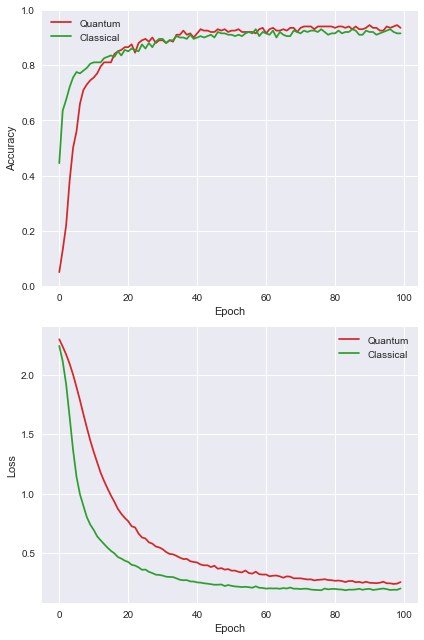

In [ ]:
def plot(model_q, model_c):

    plt.style.use("seaborn")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

    # Plotting the graph for accuracy
    ax1.plot(model_q.history.history['val_accuracy'], color="tab:red", label="Quantum")
    ax1.plot(model_c.history.history['val_accuracy'], color="tab:green", label="Classical")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0,1])
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # Plotting the graph for loss
    ax2.plot(model_q.history.history['val_loss'], color="tab:red", label="Quantum")
    ax2.plot(model_c.history.history['val_loss'], color="tab:green", label="Classical")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot(model_q, model_c)

## Evaluating the Model

Let us now compare the behaviour of the two models. We do this by running the test images through each with the optimised weights and biases and seeing the results of the classification. This process is implemented using the Classification class, shown below.

<details>
  <summary>Our classification is printed here (misclassified images are in red). Click to expand.</summary>
    
##### Quantum Model:
    
187  classified correctly  
13  classified incorrectly  

Image 1/200  
model predicts: 7 - true classification: 7  
Image 2/200  
model predicts: 2 - true classification: 2  
Image 3/200  
model predicts: 1 - true classification: 1  
Image 4/200  
model predicts: 0 - true classification: 0  
Image 5/200  
model predicts: 4 - true classification: 4  
Image 6/200  
model predicts: 1 - true classification: 1  
Image 7/200  
model predicts: 4 - true classification: 4  
Image 8/200  
model predicts: 9 - true classification: 9  
Image 9/200  
model predicts: 5 - true classification: 5  
Image 10/200  
model predicts: 9 - true classification: 9  
Image 11/200  
model predicts: 0 - true classification: 0  
Image 12/200  
model predicts: 6 - true classification: 6  
Image 13/200  
model predicts: 9 - true classification: 9  
Image 14/200  
model predicts: 0 - true classification: 0  
Image 15/200  
model predicts: 1 - true classification: 1  
Image 16/200  
model predicts: 5 - true classification: 5  
Image 17/200  
model predicts: 9 - true classification: 9  
Image 18/200  
model predicts: 7 - true classification: 7  
Image 19/200  
model predicts: 3 - true classification: 3  
Image 20/200  
model predicts: 4 - true classification: 4  
Image 21/200  
model predicts: 9 - true classification: 9  
Image 22/200  
model predicts: 6 - true classification: 6  
Image 23/200  
model predicts: 6 - true classification: 6  
Image 24/200  
model predicts: 5 - true classification: 5  
Image 25/200  
model predicts: 4 - true classification: 4  
Image 26/200  
model predicts: 0 - true classification: 0  
Image 27/200  
model predicts: 7 - true classification: 7  
Image 28/200  
model predicts: 4 - true classification: 4  
Image 29/200  
model predicts: 0 - true classification: 0  
Image 30/200  
model predicts: 1 - true classification: 1  
Image 31/200  
model predicts: 3 - true classification: 3  
Image 32/200  
model predicts: 1 - true classification: 1  
Image 33/200  
model predicts: 3 - true classification: 3  
Image 34/200  
<font color='red'>model predicts: 2 - true classification: 4</font>  
Image 35/200  
model predicts: 7 - true classification: 7  
Image 36/200  
model predicts: 2 - true classification: 2  
Image 37/200  
<font color='red'>model predicts: 2 - true classification: 7</font>  
Image 38/200  
model predicts: 1 - true classification: 1  
Image 39/200  
model predicts: 2 - true classification: 2  
Image 40/200  
model predicts: 1 - true classification: 1  
Image 41/200  
model predicts: 1 - true classification: 1  
Image 42/200  
<font color='red'>model predicts: 2 - true classification: 7</font>  
Image 43/200  
model predicts: 4 - true classification: 4  
Image 44/200  
model predicts: 2 - true classification: 2  
Image 45/200  
model predicts: 3 - true classification: 3  
Image 46/200  
model predicts: 5 - true classification: 5  
Image 47/200  
model predicts: 1 - true classification: 1  
Image 48/200  
model predicts: 2 - true classification: 2  
Image 49/200  
model predicts: 4 - true classification: 4  
Image 50/200  
model predicts: 4 - true classification: 4  
Image 51/200  
model predicts: 6 - true classification: 6  
Image 52/200  
model predicts: 3 - true classification: 3  
Image 53/200  
model predicts: 5 - true classification: 5  
Image 54/200  
<font color='red'>model predicts: 3 - true classification: 5</font>  
Image 55/200  
model predicts: 6 - true classification: 6  
Image 56/200  
model predicts: 0 - true classification: 0  
Image 57/200  
model predicts: 4 - true classification: 4  
Image 58/200  
model predicts: 1 - true classification: 1  
Image 59/200  
model predicts: 9 - true classification: 9  
Image 60/200  
model predicts: 5 - true classification: 5  
Image 61/200  
model predicts: 7 - true classification: 7  
Image 62/200  
model predicts: 8 - true classification: 8  
Image 63/200  
model predicts: 9 - true classification: 9  
Image 64/200  
model predicts: 3 - true classification: 3  
Image 65/200  
model predicts: 7 - true classification: 7  
Image 66/200  
model predicts: 4 - true classification: 4  
Image 67/200  
<font color='red'>model predicts: 2 - true classification: 6</font>  
Image 68/200  
model predicts: 4 - true classification: 4  
Image 69/200  
model predicts: 3 - true classification: 3  
Image 70/200  
model predicts: 0 - true classification: 0  
Image 71/200  
model predicts: 7 - true classification: 7  
Image 72/200  
model predicts: 0 - true classification: 0  
Image 73/200  
model predicts: 2 - true classification: 2  
Image 74/200  
<font color='red'>model predicts: 7 - true classification: 9</font>  
Image 75/200  
model predicts: 1 - true classification: 1  
Image 76/200  
model predicts: 7 - true classification: 7  
Image 77/200  
model predicts: 3 - true classification: 3  
Image 78/200  
model predicts: 2 - true classification: 2  
Image 79/200  
model predicts: 9 - true classification: 9  
Image 80/200  
model predicts: 7 - true classification: 7  
Image 81/200  
model predicts: 7 - true classification: 7  
Image 82/200  
model predicts: 6 - true classification: 6  
Image 83/200  
model predicts: 2 - true classification: 2  
Image 84/200  
model predicts: 7 - true classification: 7  
Image 85/200  
model predicts: 8 - true classification: 8  
Image 86/200  
model predicts: 4 - true classification: 4  
Image 87/200  
model predicts: 7 - true classification: 7  
Image 88/200  
model predicts: 3 - true classification: 3  
Image 89/200  
model predicts: 6 - true classification: 6  
Image 90/200  
model predicts: 1 - true classification: 1  
Image 91/200  
model predicts: 3 - true classification: 3  
Image 92/200  
model predicts: 6 - true classification: 6  
Image 93/200  
model predicts: 9 - true classification: 9  
Image 94/200  
model predicts: 3 - true classification: 3  
Image 95/200  
model predicts: 1 - true classification: 1  
Image 96/200  
model predicts: 4 - true classification: 4  
Image 97/200  
model predicts: 1 - true classification: 1  
Image 98/200  
model predicts: 7 - true classification: 7  
Image 99/200  
model predicts: 6 - true classification: 6  
Image 100/200  
model predicts: 9 - true classification: 9  
Image 101/200  
model predicts: 6 - true classification: 6  
Image 102/200  
model predicts: 0 - true classification: 0  
Image 103/200  
model predicts: 5 - true classification: 5  
Image 104/200  
model predicts: 4 - true classification: 4  
Image 105/200  
model predicts: 9 - true classification: 9  
Image 106/200  
model predicts: 9 - true classification: 9  
Image 107/200  
model predicts: 2 - true classification: 2  
Image 108/200  
model predicts: 1 - true classification: 1  
Image 109/200  
model predicts: 9 - true classification: 9  
Image 110/200  
model predicts: 4 - true classification: 4  
Image 111/200  
model predicts: 8 - true classification: 8  
Image 112/200  
model predicts: 7 - true classification: 7  
Image 113/200  
model predicts: 3 - true classification: 3  
Image 114/200  
model predicts: 9 - true classification: 9  
Image 115/200  
model predicts: 7 - true classification: 7  
Image 116/200  
model predicts: 4 - true classification: 4  
Image 117/200  
model predicts: 4 - true classification: 4  
Image 118/200  
model predicts: 4 - true classification: 4  
Image 119/200  
model predicts: 9 - true classification: 9  
Image 120/200  
<font color='red'>model predicts: 8 - true classification: 2</font>  
Image 121/200  
model predicts: 5 - true classification: 5  
Image 122/200  
model predicts: 4 - true classification: 4  
Image 123/200  
model predicts: 7 - true classification: 7  
Image 124/200  
model predicts: 6 - true classification: 6  
Image 125/200  
model predicts: 7 - true classification: 7  
Image 126/200  
model predicts: 9 - true classification: 9  
Image 127/200  
<font color='red'>model predicts: 2 - true classification: 0</font>  
Image 128/200  
model predicts: 5 - true classification: 5  
Image 129/200  
model predicts: 8 - true classification: 8  
Image 130/200  
model predicts: 5 - true classification: 5  
Image 131/200  
model predicts: 6 - true classification: 6  
Image 132/200  
model predicts: 6 - true classification: 6  
Image 133/200  
model predicts: 5 - true classification: 5  
Image 134/200  
model predicts: 7 - true classification: 7  
Image 135/200  
model predicts: 8 - true classification: 8  
Image 136/200  
model predicts: 1 - true classification: 1  
Image 137/200  
model predicts: 0 - true classification: 0  
Image 138/200  
model predicts: 1 - true classification: 1  
Image 139/200  
model predicts: 6 - true classification: 6  
Image 140/200  
model predicts: 4 - true classification: 4  
Image 141/200  
model predicts: 6 - true classification: 6  
Image 142/200  
model predicts: 7 - true classification: 7  
Image 143/200  
<font color='red'>model predicts: 2 - true classification: 3</font>  
Image 144/200  
model predicts: 1 - true classification: 1  
Image 145/200  
model predicts: 7 - true classification: 7  
Image 146/200  
model predicts: 1 - true classification: 1  
Image 147/200  
model predicts: 8 - true classification: 8  
Image 148/200  
model predicts: 2 - true classification: 2  
Image 149/200  
model predicts: 0 - true classification: 0  
Image 150/200  
<font color='red'>model predicts: 9 - true classification: 2</font>  
Image 151/200  
model predicts: 9 - true classification: 9  
Image 152/200  
<font color='red'>model predicts: 4 - true classification: 9</font>  
Image 153/200  
model predicts: 5 - true classification: 5  
Image 154/200  
model predicts: 5 - true classification: 5  
Image 155/200  
model predicts: 1 - true classification: 1  
Image 156/200  
model predicts: 5 - true classification: 5  
Image 157/200  
model predicts: 6 - true classification: 6  
Image 158/200  
model predicts: 0 - true classification: 0  
Image 159/200  
model predicts: 3 - true classification: 3  
Image 160/200  
model predicts: 4 - true classification: 4  
Image 161/200  
model predicts: 4 - true classification: 4  
Image 162/200  
model predicts: 6 - true classification: 6  
Image 163/200  
model predicts: 5 - true classification: 5  
Image 164/200  
model predicts: 4 - true classification: 4  
Image 165/200  
model predicts: 6 - true classification: 6  
Image 166/200  
<font color='red'>model predicts: 8 - true classification: 5</font>  
Image 167/200  
model predicts: 4 - true classification: 4  
Image 168/200  
model predicts: 5 - true classification: 5  
Image 169/200  
model predicts: 1 - true classification: 1  
Image 170/200  
model predicts: 4 - true classification: 4  
Image 171/200  
model predicts: 4 - true classification: 4  
Image 172/200  
model predicts: 7 - true classification: 7  
Image 173/200  
model predicts: 2 - true classification: 2  
Image 174/200  
model predicts: 3 - true classification: 3  
Image 175/200  
model predicts: 2 - true classification: 2  
Image 176/200  
model predicts: 7 - true classification: 7  
Image 177/200  
model predicts: 1 - true classification: 1  
Image 178/200  
model predicts: 8 - true classification: 8  
Image 179/200  
model predicts: 1 - true classification: 1  
Image 180/200  
model predicts: 8 - true classification: 8  
Image 181/200  
model predicts: 1 - true classification: 1  
Image 182/200  
model predicts: 8 - true classification: 8  
Image 183/200  
model predicts: 5 - true classification: 5  
Image 184/200  
model predicts: 0 - true classification: 0  
Image 185/200  
<font color='red'>model predicts: 3 - true classification: 8</font>  
Image 186/200  
model predicts: 9 - true classification: 9  
Image 187/200  
model predicts: 2 - true classification: 2  
Image 188/200  
model predicts: 5 - true classification: 5  
Image 189/200  
model predicts: 0 - true classification: 0  
Image 190/200  
model predicts: 1 - true classification: 1  
Image 191/200  
model predicts: 1 - true classification: 1  
Image 192/200  
model predicts: 1 - true classification: 1  
Image 193/200  
model predicts: 0 - true classification: 0  
Image 194/200  
model predicts: 9 - true classification: 9  
Image 195/200  
model predicts: 0 - true classification: 0  
Image 196/200  
model predicts: 3 - true classification: 3  
Image 197/200  
model predicts: 1 - true classification: 1  
Image 198/200  
model predicts: 6 - true classification: 6  
Image 199/200  
model predicts: 4 - true classification: 4  
Image 200/200  
model predicts: 2 - true classification: 2  

##### Classical Model:
183  classified correctly  
17  classified incorrectly  

Image 1/200  
model predicts: 7 - true classification: 7  
Image 2/200  
model predicts: 2 - true classification: 2  
Image 3/200  
model predicts: 1 - true classification: 1  
Image 4/200  
model predicts: 0 - true classification: 0  
Image 5/200  
model predicts: 4 - true classification: 4  
Image 6/200  
model predicts: 1 - true classification: 1  
Image 7/200  
model predicts: 4 - true classification: 4  
Image 8/200  
<font color='red'>model predicts: 8 - true classification: 9</font>  
Image 9/200  
model predicts: 5 - true classification: 5  
Image 10/200  
model predicts: 9 - true classification: 9  
Image 11/200  
model predicts: 0 - true classification: 0  
Image 12/200  
model predicts: 6 - true classification: 6  
Image 13/200  
model predicts: 9 - true classification: 9  
Image 14/200  
model predicts: 0 - true classification: 0  
Image 15/200  
model predicts: 1 - true classification: 1  
Image 16/200  
<font color='red'>model predicts: 3 - true classification: 5</font>  
Image 17/200  
model predicts: 9 - true classification: 9  
Image 18/200  
model predicts: 7 - true classification: 7  
Image 19/200  
model predicts: 3 - true classification: 3  
Image 20/200  
model predicts: 4 - true classification: 4  
Image 21/200  
<font color='red'>model predicts: 7 - true classification: 9</font>  
Image 22/200  
model predicts: 6 - true classification: 6  
Image 23/200  
<font color='red'>model predicts: 7 - true classification: 6</font>  
Image 24/200  
model predicts: 5 - true classification: 5  
Image 25/200  
model predicts: 4 - true classification: 4  
Image 26/200  
model predicts: 0 - true classification: 0  
Image 27/200  
model predicts: 7 - true classification: 7  
Image 28/200  
model predicts: 4 - true classification: 4  
Image 29/200  
model predicts: 0 - true classification: 0  
Image 30/200  
model predicts: 1 - true classification: 1  
Image 31/200  
model predicts: 3 - true classification: 3  
Image 32/200  
model predicts: 1 - true classification: 1  
Image 33/200  
model predicts: 3 - true classification: 3  
Image 34/200  
model predicts: 4 - true classification: 4  
Image 35/200  
model predicts: 7 - true classification: 7  
Image 36/200  
model predicts: 2 - true classification: 2  
Image 37/200  
model predicts: 7 - true classification: 7  
Image 38/200  
model predicts: 1 - true classification: 1  
Image 39/200  
model predicts: 2 - true classification: 2  
Image 40/200  
model predicts: 1 - true classification: 1  
Image 41/200  
model predicts: 1 - true classification: 1  
Image 42/200  
model predicts: 7 - true classification: 7  
Image 43/200  
model predicts: 4 - true classification: 4  
Image 44/200  
model predicts: 2 - true classification: 2  
Image 45/200  
model predicts: 3 - true classification: 3  
Image 46/200  
model predicts: 5 - true classification: 5  
Image 47/200  
model predicts: 1 - true classification: 1  
Image 48/200  
model predicts: 2 - true classification: 2  
Image 49/200  
model predicts: 4 - true classification: 4  
Image 50/200  
model predicts: 4 - true classification: 4  
Image 51/200  
model predicts: 6 - true classification: 6  
Image 52/200  
model predicts: 3 - true classification: 3  
Image 53/200  
model predicts: 5 - true classification: 5  
Image 54/200  
<font color='red'>model predicts: 8 - true classification: 5</font>  
Image 55/200  
model predicts: 6 - true classification: 6  
Image 56/200  
model predicts: 0 - true classification: 0  
Image 57/200  
model predicts: 4 - true classification: 4  
Image 58/200  
model predicts: 1 - true classification: 1  
Image 59/200  
model predicts: 9 - true classification: 9  
Image 60/200  
<font color='red'>model predicts: 9 - true classification: 5</font>  
Image 61/200  
<font color='red'>model predicts: 3 - true classification: 7</font>  
Image 62/200  
model predicts: 8 - true classification: 8  
Image 63/200  
model predicts: 9 - true classification: 9  
Image 64/200  
model predicts: 3 - true classification: 3  
Image 65/200  
model predicts: 7 - true classification: 7  
Image 66/200  
model predicts: 4 - true classification: 4  
Image 67/200  
<font color='red'>model predicts: 2 - true classification: 6</font>  
Image 68/200  
model predicts: 4 - true classification: 4  
Image 69/200  
model predicts: 3 - true classification: 3  
Image 70/200  
model predicts: 0 - true classification: 0  
Image 71/200  
model predicts: 7 - true classification: 7  
Image 72/200  
model predicts: 0 - true classification: 0  
Image 73/200  
model predicts: 2 - true classification: 2  
Image 74/200  
<font color='red'>model predicts: 7 - true classification: 9</font>  
Image 75/200  
model predicts: 1 - true classification: 1  
Image 76/200  
model predicts: 7 - true classification: 7  
Image 77/200  
model predicts: 3 - true classification: 3  
Image 78/200  
model predicts: 2 - true classification: 2  
Image 79/200  
model predicts: 9 - true classification: 9  
Image 80/200  
model predicts: 7 - true classification: 7  
Image 81/200  
model predicts: 7 - true classification: 7  
Image 82/200  
model predicts: 6 - true classification: 6  
Image 83/200  
model predicts: 2 - true classification: 2  
Image 84/200  
model predicts: 7 - true classification: 7  
Image 85/200  
model predicts: 8 - true classification: 8  
Image 86/200  
model predicts: 4 - true classification: 4  
Image 87/200  
model predicts: 7 - true classification: 7  
Image 88/200  
model predicts: 3 - true classification: 3  
Image 89/200  
model predicts: 6 - true classification: 6  
Image 90/200  
model predicts: 1 - true classification: 1  
Image 91/200  
model predicts: 3 - true classification: 3  
Image 92/200  
model predicts: 6 - true classification: 6  
Image 93/200  
<font color='red'>model predicts: 4 - true classification: 9</font>  
Image 94/200  
model predicts: 3 - true classification: 3  
Image 95/200  
model predicts: 1 - true classification: 1  
Image 96/200  
model predicts: 4 - true classification: 4  
Image 97/200  
model predicts: 1 - true classification: 1  
Image 98/200  
model predicts: 7 - true classification: 7  
Image 99/200  
model predicts: 6 - true classification: 6  
Image 100/200  
model predicts: 9 - true classification: 9  
Image 101/200  
model predicts: 6 - true classification: 6  
Image 102/200  
model predicts: 0 - true classification: 0  
Image 103/200  
model predicts: 5 - true classification: 5  
Image 104/200  
model predicts: 4 - true classification: 4  
Image 105/200  
model predicts: 9 - true classification: 9  
Image 106/200  
model predicts: 9 - true classification: 9  
Image 107/200  
model predicts: 2 - true classification: 2  
Image 108/200  
model predicts: 1 - true classification: 1  
Image 109/200  
model predicts: 9 - true classification: 9  
Image 110/200  
model predicts: 4 - true classification: 4  
Image 111/200  
model predicts: 8 - true classification: 8  
Image 112/200  
model predicts: 7 - true classification: 7  
Image 113/200  
<font color='red'>model predicts: 5 - true classification: 3</font>  
Image 114/200  
model predicts: 9 - true classification: 9  
Image 115/200  
model predicts: 7 - true classification: 7  
Image 116/200  
model predicts: 4 - true classification: 4  
Image 117/200  
model predicts: 4 - true classification: 4  
Image 118/200  
model predicts: 4 - true classification: 4  
Image 119/200  
model predicts: 9 - true classification: 9  
Image 120/200  
model predicts: 2 - true classification: 2  
Image 121/200  
model predicts: 5 - true classification: 5  
Image 122/200  
model predicts: 4 - true classification: 4  
Image 123/200  
model predicts: 7 - true classification: 7  
Image 124/200  
model predicts: 6 - true classification: 6  
Image 125/200  
<font color='red'>model predicts: 4 - true classification: 7</font>  
Image 126/200  
model predicts: 9 - true classification: 9  
Image 127/200  
model predicts: 0 - true classification: 0  
Image 128/200  
model predicts: 5 - true classification: 5  
Image 129/200  
model predicts: 8 - true classification: 8  
Image 130/200  
model predicts: 5 - true classification: 5  
Image 131/200  
model predicts: 6 - true classification: 6  
Image 132/200  
model predicts: 6 - true classification: 6  
Image 133/200  
model predicts: 5 - true classification: 5  
Image 134/200  
<font color='red'>model predicts: 2 - true classification: 7</font>  
Image 135/200  
model predicts: 8 - true classification: 8  
Image 136/200  
model predicts: 1 - true classification: 1  
Image 137/200  
model predicts: 0 - true classification: 0  
Image 138/200  
model predicts: 1 - true classification: 1  
Image 139/200  
model predicts: 6 - true classification: 6  
Image 140/200  
model predicts: 4 - true classification: 4  
Image 141/200  
model predicts: 6 - true classification: 6  
Image 142/200  
model predicts: 7 - true classification: 7  
Image 143/200  
model predicts: 3 - true classification: 3  
Image 144/200  
model predicts: 1 - true classification: 1  
Image 145/200  
model predicts: 7 - true classification: 7  
Image 146/200  
model predicts: 1 - true classification: 1  
Image 147/200  
model predicts: 8 - true classification: 8  
Image 148/200  
model predicts: 2 - true classification: 2  
Image 149/200  
model predicts: 0 - true classification: 0  
Image 150/200  
model predicts: 2 - true classification: 2  
Image 151/200  
model predicts: 9 - true classification: 9  
Image 152/200  
model predicts: 9 - true classification: 9  
Image 153/200  
model predicts: 5 - true classification: 5  
Image 154/200  
model predicts: 5 - true classification: 5  
Image 155/200  
model predicts: 1 - true classification: 1  
Image 156/200  
model predicts: 5 - true classification: 5  
Image 157/200  
model predicts: 6 - true classification: 6  
Image 158/200  
model predicts: 0 - true classification: 0  
Image 159/200  
model predicts: 3 - true classification: 3  
Image 160/200  
<font color='red'>model predicts: 9 - true classification: 4</font>  
Image 161/200  
model predicts: 4 - true classification: 4  
Image 162/200  
model predicts: 6 - true classification: 6  
Image 163/200  
model predicts: 5 - true classification: 5  
Image 164/200  
model predicts: 4 - true classification: 4  
Image 165/200  
model predicts: 6 - true classification: 6  
Image 166/200  
model predicts: 5 - true classification: 5  
Image 167/200  
model predicts: 4 - true classification: 4  
Image 168/200  
<font color='red'>model predicts: 3 - true classification: 5</font>  
Image 169/200  
model predicts: 1 - true classification: 1  
Image 170/200  
model predicts: 4 - true classification: 4  
Image 171/200  
model predicts: 4 - true classification: 4  
Image 172/200  
model predicts: 7 - true classification: 7  
Image 173/200  
model predicts: 2 - true classification: 2  
Image 174/200  
model predicts: 3 - true classification: 3  
Image 175/200  
model predicts: 2 - true classification: 2  
Image 176/200  
model predicts: 7 - true classification: 7  
Image 177/200  
model predicts: 1 - true classification: 1  
Image 178/200  
<font color='red'>model predicts: 9 - true classification: 8</font>  
Image 179/200  
model predicts: 1 - true classification: 1  
Image 180/200  
model predicts: 8 - true classification: 8  
Image 181/200  
model predicts: 1 - true classification: 1  
Image 182/200  
model predicts: 8 - true classification: 8  
Image 183/200  
model predicts: 5 - true classification: 5  
Image 184/200  
model predicts: 0 - true classification: 0  
Image 185/200  
model predicts: 8 - true classification: 8  
Image 186/200  
model predicts: 9 - true classification: 9  
Image 187/200  
model predicts: 2 - true classification: 2  
Image 188/200  
model predicts: 5 - true classification: 5  
Image 189/200  
model predicts: 0 - true classification: 0  
Image 190/200  
model predicts: 1 - true classification: 1  
Image 191/200  
model predicts: 1 - true classification: 1  
Image 192/200  
model predicts: 1 - true classification: 1  
Image 193/200  
model predicts: 0 - true classification: 0  
Image 194/200  
model predicts: 9 - true classification: 9  
Image 195/200  
model predicts: 0 - true classification: 0  
Image 196/200  
<font color='red'>model predicts: 8 - true classification: 3</font>  
Image 197/200  
model predicts: 1 - true classification: 1  
Image 198/200  
model predicts: 6 - true classification: 6  
Image 199/200  
model predicts: 4 - true classification: 4  
Image 200/200  
model predicts: 2 - true classification: 2  
<\details>

Overall, the quantum model misclassified images 34, 37, 42, 54, 67, 74, 120, 127, 143, 150, 152, 166, and 185. The classical model misclassified images 8, 16, 21, 23, 54, 60, 61, 67, 74, 93, 113, 125, 134, 160, 168, 178, and 196. This means that in total, the quantum model misclassified 13 images and the classical model misclassified 17 images. Of these, only images 54, 67, and 74 were misclassified by both.

In [ ]:
from termcolor import colored

class Classification:
    
    def __init__(self, model, test_images):
        # Initialising parameters
        self.model = model
        self.test_images = test_images
        self.test_labels = model.ds.test_labels

    def classify(self):
        # Create predictions on the test set
        self.predictions = np.argmax(self.model.model.predict(self.test_images), axis=-1)

        # Keep track of the indices of images which were classified correctly and incorrectly
        self.correct_indices = np.nonzero(self.predictions == self.test_labels)[0]
        self.incorrect_indices = np.nonzero(self.predictions != self.test_labels)[0]
    
    def print_(self):
        # Printing the total number of correctly and incorrectly classified images
        print(len(self.correct_indices)," classified correctly")
        print(len(self.incorrect_indices)," classified incorrectly")
        print('\n')

        # Printing the classification of each image
        for i in range(n_test):
            print("Image {}/{}".format(i+1, n_test))
            if i in self.correct_indices:
                # The image was correctly classified
                print('model predicts: {} - true classification: {}'.format(
                    self.predictions[i], self.test_labels[i]))
            else:
                # The image was not classified correctly
                print(colored('model predicts: {} - true classification: {}'.format(
                    self.predictions[i], self.test_labels[i]), 'red'))

In [ ]:
print('Quantum Model')
q_class = Classification(model_q, model_q.q_test_images)
q_class.classify()
q_class.print_()

print('\n')

print('Classical Model')
c_class = Classification(model_c, model_c.ds.test_images)
c_class.classify()
c_class.print_()

Lastly, we can see the effect that the quantum convolutional layer actually has on the images by plotting images after they have been run through the quantum filters, and to do this we use the function visualise, shown below. Included in this text box is a plot showing four images which have been run through our filters. The top row shows images from the original dataset, and each subsequent row shows the result from each of the four filters on that original image. It can be seen that the processing preserves the global shape of the digit while introducing local distortion.
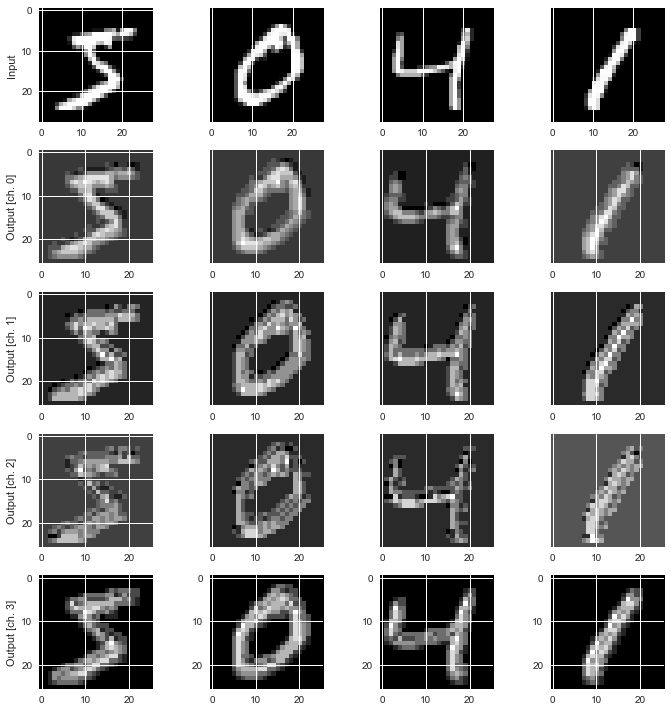

In [ ]:
def visualise(model):
    # Setting n_samples to be the number of images to print
    n_samples = 4
    
    fig, axes = plt.subplots(1 + n_filters, n_samples, figsize=(10, 10))
    
    # Iterate over each image
    for i in range(n_samples):
        
        # Plot the original image from the dataset
        axes[0, 0].set_ylabel("Input")
        if i != 0:
            axes[0, i].yaxis.set_visible(False)
        axes[0, i].imshow(model.ds.train_images[i, :, :, 0], cmap="gray")

        # Plot the images generated by each filter
        for c in range(n_filters):
            axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
            if i != 0:
                axes[c, i].yaxis.set_visible(False)
            axes[c + 1, i].imshow(model.q_train_images[i, :, :, c], cmap="gray")

    plt.tight_layout()
    plt.show()
    
visualise(model_q)

#### Resources used to make this tutorial:

1. [Pennylane: Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution.html)
2. Henderson, M., Shakya, S., Pradhan, S. et al. Quanvolutional neural networks: powering image recognition with quantum circuits. Quantum Mach. Intell. 2, 1–9 (2020). https://doi.org/10.1007/s42484-020-00012-y
3. [Keras for Beginners: Implementing a Convolutional Neural Network. Victor Zhou](https://victorzhou.com/blog/keras-cnn-tutorial/).
4. [CNNs, Part 1: An Introduction to Convolutional Neural Networks. Victor Zhou](https://victorzhou.com/blog/intro-to-cnns-part-1/).
5. [How Convolutional Neural Networks work](https://www.youtube.com/watch?v=FmpDIaiMIeA)
6. [Neural Networks and Deep Learning, chapter 6. Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap6.html)